# Lab 5a - Hierarchical Clustering Methods

This notebook introduces the first of two Classic Clustering Methods, i.e., Hierarchical Clustering. Special aspects considered include the visualization and spatial analysis of the cluster results.

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
We will consider agglomerative clustering as an example of hierarchical clustering.

The empirical illustration is based on the material in Chapter 5 of the Spatial Cluster book.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

In addition to the usual numpy, geopandas and matplotlib, we also import several specialized packages from scikit-learn. Specifically, to carry out variable standardization we import `StandardScaler` from `sklearn.preprocessing`. The specific clustering method is `AgglomerativeClustering` from `sklearn.cluster`. In addition, an alternative method to obtain hierarchical clusters, which is somewhat easier to visualize, is contained in `scipy.cluster.hierarchy`. 

Finally, to implement some of the *spatialization* of these methods, we import several functions from the `spatial_cluster_course` utility module (this requires that the latest version of the file spatial_cluster_course.py is in the current working directory):
- `cluster_stats`
- `plot_clusters`
- `plot_dendrogram`
- `cluster_center`
- `cluster_fit`
- `cluster_map`

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage

from spatial_cluster_course import cluster_stats, plot_dendrogram, cluster_center, cluster_fit, cluster_map

### Load data

For this exercise, we will use a data set on socio-economic variables for Chicago Community Areas in 2020 in Chicago, IL. This is also a GeoDa sample data set. Detailed source and information available at https://geodacenter.github.io/data-and-lab/Chi-CCA/

The following files will be used:
- **Chicago_2020.shp,shx,dbf,prj**: shape file (four files) for 77 community areas

We follow the usual practice of setting a path (if needed), reading the data from the shape file and a quick check of its contents (`head`).

In [2]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Chicago community area data:
dfs = gpd.read_file(path+"Chi_CCA/Chicago_2020_sdoh.shp")
print(dfs.shape)
dfs.head(3)

(77, 233)


,area_num_1,community,shape_area,shape_len,districtno,district,TOT_POP,2000_POP,2010_POP,UND5,...,KOREAN,OTHASIAN,OTHER_EURO,OTHUNSPEC,2000_WHITE,2000_HISP,2000_BLACK,2000_ASIAN,2000_OTHER,geometry
0,35.0,DOUGLAS,4.600462e+07,31027.054510,7.0,South Side,21325.0,26470.0,18238.0,1107.0,...,145.0,571.0,1290.0,555.0,1745.0,295.0,22635.0,1390.0,405.0,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,36.0,OAKLAND,1.691396e+07,19565.506153,7.0,South Side,7227.0,6110.0,5918.0,574.0,...,0.0,22.0,98.0,342.0,40.0,58.0,5957.0,8.0,47.0,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,37.0,FULLER PARK,1.991670e+07,25339.089750,7.0,South Side,2394.0,3420.0,2876.0,120.0,...,0.0,0.0,15.0,0.0,18.0,116.0,3225.0,6.0,55.0,"POLYGON ((-87.6288 41.80189, -87.62879 41.8017..."


In [3]:
# the full set of variables
print(list(dfs.columns))

['area_num_1', 'community', 'shape_area', 'shape_len', 'districtno', 'district', 'TOT_POP', '2000_POP', '2010_POP', 'UND5', 'A5_19', 'A65_74', 'A75_84', 'OV85', 'WHITE', 'UNEMP', 'NO_VEH', 'POP_25OV', 'LT_HS', 'MEDINC', 'TOT_HH', 'OWN_OCC_HU', 'RENTOCCHU', 'VAC_HU', 'HU_TOT', 'MED_HA', 'MED_HV', 'MED_RENT', 'AVG_VMT', 'FOR_BORN', 'POP_OV5', 'NOTENGLISH', 'LING_ISO', 'INCPERCAP', 'Und20', 'Ov65', 'Minrty', 'Unemprt', 'Noveh', 'Lt_high', 'Rentocc', 'Rntburd', 'Noeng', 'Vacant', 'Forborn', 'Ownocc', 'Liteng', 'CLhc5', 'GEOID', 'GEOG', 'A5_20', 'A20_34', 'A35_49', 'A50_64', 'A65_75', 'A75_85', 'MED_AGE', 'HISP', 'BLACK', 'ASIAN', 'OTHER', 'POP_HH', 'POP_16OV', 'IN_LBFRC', 'EMP', 'N_IN_LBFRC', 'T_WRKR16OV', 'WORK_HOME', 'TOT_COMM', 'DROVE_AL', 'CARPOOL', 'TRANSIT', 'WALK_BIKE', 'COMM_OTHER', 'AGG_TT', 'ONE_VEH', 'TWO_VEH', 'THREEP_VEH', 'HS', 'SOME_COLL', 'ASSOC', 'BACH', 'GRAD_PROF', 'INCLT25K', 'INC2550K', 'INC5075K', 'INC75100K', 'INC100150K', 'INC_GT_150', 'HU_SNG_DET', 'HU_SNG_ATT', 'H

#### Selecting variables and checking their correlation

Following Section 5.4 of Anselin (2024) (https://lanselin.github.io/introbook_vol2/implementation-3.html), the variables in our Chicago Community Areas sample data set form a subset of the variables identified in Kolak et al. (2020) in an analysis that includes all U.S. census tracts.

List of variables:
| Column Name | Description                                                                 |
|-------------|-----------------------------------------------------------------------------|
| INCPERCAP   | Per capita income                                                          |
| Und20       | Population share aged < 20                                                |
| Ov65        | Population share aged > 65                                                |
| Minrty      | Percentage of minority population |
| Unemprt     | Unemployment rate                                                         |
| Noveh       | Percentage of households with no vehicle                                   |
| Lt_high     | Percentage of population without high school education                    |
| Rentocc     | Percentage of renter-occupied housing                                      |
| Rntburd     | Rent burden                                                               |
| Noeng       | Percentage of population with limited English proficiency                 |

We start by computing simple descriptive statistics by applying the `describe` method to the subset of the data frame that contains the selected variables. The results are rounded to two decimals.

In [4]:
varlist = ['INCPERCAP', 'Und20', 'Ov65', 'Minrty', 'Unemprt', 
           'Noveh', 'Lt_high', 'Rentocc', 'Rntburd', 'Noeng']
data_cluster = dfs[varlist]

round(data_cluster.describe(),2)

,INCPERCAP,Und20,Ov65,Minrty,Unemprt,Noveh,Lt_high,Rentocc,Rntburd,Noeng
count,77.00,77.00,77.00,77.00,77.00,77.00,77.00,77.00,77.00,77.00
mean,32501.26,24.56,13.69,72.05,10.56,12.73,16.00,45.20,25.71,33.38
std,19482.12,6.35,4.61,26.91,6.87,8.01,9.63,15.75,8.26,26.73
min,11857.00,8.90,4.80,16.79,0.37,1.93,1.73,9.13,11.23,2.19
25%,19842.00,20.25,10.12,51.74,5.01,6.04,9.12,31.70,20.40,7.38
50%,25944.00,25.08,12.82,85.51,8.74,10.53,14.69,48.36,23.94,26.71
75%,36736.00,29.41,16.09,96.37,15.74,19.92,21.70,56.20,29.80,55.36
max,101727.00,44.28,26.52,99.50,30.42,34.31,44.65,76.92,49.85,86.53


## Hierarchical Clustering

The first class of traditional clustering methods builds up the clusters step-by-step in a *hierarchical* fashion. There are two approaches. One, agglomerative clustering, starts from the bottom and works its way up. More precisely, initially, each observation forms a separate cluster and subsequently pairs of observations are systematically grouped into larger entities, until the whole data set forms one cluster. In the other approach, divisive clustering, the opposite path is taken. One starts with the full set of observations as one cluster, and subsequently splits this into subclusters until each observation is again its own cluster. Here, we only consider agglomerative clustering. A form of divisive clustering is considered in the discussion of spatially constrained clustering.

There are two important elements to be considered in the grouping of observations:
- linkage option, i.e., how to decide which observations/clusters are *closest*
- update function, i.e., how to compute the *distance* between clusters

The main methods are characterized by different linkage options. Here, we consider the four most common ones, i.e., *Ward's* method, *single linkage*, *complete linkage* and *average linkage*.

An important aspect of hierarchical clustering is the so-called *dendrogram*, which visualizes the process of grouping observations/entities into larger entities and the associated distance criterion. The number of clusters is not set initially, but is determined by the *cut* of the dendrogram.

We start by considering Ward's method, which is arguably the most robust and most commonly used method. However, it only works for a squared distance criterion, whereas other measures work with any distance. We illustrate four important aspects of the solution: computing the clusters (cluster labels), visualizing the dendrogram, calculating characteristics of a cluster solution, and visualizing the clusters in a *cluster map*.

## Ward's method

### Cluster Computation

One approach to obtain the cluster computation is by means of the `AgglomerativeClustering` class of scikit-learn. For details, see https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html. The second option, using `scipy.cluster.hierarchy` is considered in the discussion of the dendrogram next.

The main arguments to create an instance of the `AgglomerativeClustering` class are the number of clusters, `n_clusters`, the `linkage` option, as well as an option to compute the distances from an initial array of inputs, `compute_distances = True`. As before, the input data frame is first standardized using `fit_transform` from `StandardScaler`. Once an instance of the class is created, the `fit` method returns the results, with the cluster labels contained in the `labels_` attribute. Other attributes are provided as well, but the labels are our main interest (see the docs for details). We summarize the results with our `cluster_stats` utility function (contained in `spatial_cluster_course.py` and outlined in a previous notebook).

We illustrate this for Ward's method with a cluster size of 5.

In [5]:
# Select the desired number of clusters and linkage method
n_clusters = 5
method = 'ward'

# Standardize the data (Z-transformation)
X = StandardScaler().fit_transform(data_cluster)

# Fit Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage=method, compute_distances=True)
agg_clust.fit(X)
cluster_labels = agg_clust.labels_
cluster_stats(cluster_labels)

,Labels,Cardinality
0,0,21
1,1,15
2,2,15
3,3,13
4,4,13


The resulting clusters are labeled from 0 to 4. They are relatively balanced, with 21 observations in the largest cluster, two clusters with 15 and two clusters with 13. 

An interesting piece of information is contained in the `distances_` attribute. This shows the distances at which each cluster is formed, increasing from the smallest distance (here 0.36) to the one between the final two clusters that form the full data set (here 20.3).

In [6]:
agg_clust.distances_

array([ 0.36274015,  0.53936027,  0.68178409,  0.71372655,  0.78778369,
        0.79647585,  0.84125925,  0.84297015,  0.85370346,  0.8831146 ,
        0.88675916,  0.92955806,  0.98841925,  1.05998996,  1.06438798,
        1.07255791,  1.0765715 ,  1.1538963 ,  1.21130411,  1.25532594,
        1.27768021,  1.32193569,  1.35293476,  1.36454495,  1.37498667,
        1.37632845,  1.39756016,  1.41986327,  1.42228951,  1.42756184,
        1.46881725,  1.51405012,  1.52158604,  1.53340115,  1.5670125 ,
        1.73174358,  1.73496471,  1.78386891,  1.84018742,  1.89045915,
        1.91123968,  1.94707456,  1.95727687,  1.99076458,  2.00088467,
        2.04991017,  2.14413004,  2.28039251,  2.31301355,  2.41508411,
        2.43475984,  2.47209374,  2.5891719 ,  2.63945666,  2.70434923,
        2.85506842,  3.01764305,  3.08092386,  3.10174269,  3.14956205,
        3.2148449 ,  4.25006606,  4.29530368,  4.56351567,  4.97645808,
        5.18803816,  5.32611836,  5.50111751,  5.85655264,  6.29

### Dendrogram

The scikit-learn functionality does not return a dendrogram. To visualize the hierarchy of grouping decisions, we use an alternative implementation, which is part of `scipy.cluster`, namely `scipy.cluster.hierarchy`. The setup is somewhat different from the scikit-learn approach and provides functions to compute hierarchical cluster results, with `linkage`. This returns a hierarchical cluster as a numpy array (see below), which can then be visualized as a `dendrogram`. In addition, other summaries are available as well, see https://docs.scipy.org/doc/scipy-1.15.0/reference/cluster.hierarchy.html for details.

We illustrate this for our example. In a first step, we create the cluster result by applying `linkage` to the array `X` with the standardized values (the same as used above). A second argument is the method, again `"ward"`. This returns a numpy array with all the linkage information expressed in a n-1 by 4 matrix. In each row, the first two elements refer to cluster indices that are being combined, with values less than n referring to original observations, and values of n and larger referring to clusters that are combinations of earlier clusters. The third column gives the inter-cluster distance and the last column shows the number of original observations contained in the cluster.

The inter-cluster distance shown in the third column is the same as what we had in the `distances` attribute of the cluster constructed with scikit-learn.

In our example, we list the first five rows. In the first row, individual observations 59 and 62 are combined to yield a cluster of two (element in column 4). In the third row, observation 50 is combined with 77, which is the first cluster (or 59 and 62). As a result, it now consists of 3 elements (shown in the fourth column).

In [7]:
Z = linkage(X, method='ward')
print(Z.shape)
print(Z[0:5,:])

(76, 4)
[[59.         62.          0.36274015  2.        ]
 [13.         21.          0.53936027  2.        ]
 [50.         77.          0.68178409  3.        ]
 [18.         20.          0.71372655  2.        ]
 [ 5.         22.          0.78778369  2.        ]]


The full set of distances (column 2) is identical to the values contained in `distances` above.

In [8]:
Z[:,2]

array([ 0.36274015,  0.53936027,  0.68178409,  0.71372655,  0.78778369,
        0.79647585,  0.84125925,  0.84297015,  0.85370346,  0.8831146 ,
        0.88675916,  0.92955806,  0.98841925,  1.05998996,  1.06438798,
        1.07255791,  1.0765715 ,  1.1538963 ,  1.21130411,  1.25532594,
        1.27768021,  1.32193569,  1.35293476,  1.36454495,  1.37498667,
        1.37632845,  1.39756016,  1.41986327,  1.42228951,  1.42756184,
        1.46881725,  1.51405012,  1.52158604,  1.53340115,  1.5670125 ,
        1.73174358,  1.73496471,  1.78386891,  1.84018742,  1.89045915,
        1.91123968,  1.94707456,  1.95727687,  1.99076458,  2.00088467,
        2.04991017,  2.14413004,  2.28039251,  2.31301355,  2.41508411,
        2.43475984,  2.47209374,  2.5891719 ,  2.63945666,  2.70434923,
        2.85506842,  3.01764305,  3.08092386,  3.10174269,  3.14956205,
        3.2148449 ,  4.25006606,  4.29530368,  4.56351567,  4.97645808,
        5.18803816,  5.32611836,  5.50111751,  5.85655264,  6.29

We can now proceed and graph the dendrogram. The `dendrogram` function takes the linkage array (`Z`) as well as several other arguments to fine tune the looks of the graph. The most important of these is `color_threshold`, which is the cut-off distance to define the clusters. Since the distances in `Z` are sorted from smallest to largest, the top distance corresponds to a single cluster, the next to last to a result with two clusters, etc. As a result, the cut-off distance for `n_clusters` is contained in position - (n_clusters - 1), or 1 - n_clusters. We pass this distance to `color_threshold` so that all the branches corresponding to each cluster are colored the same in the graph.

Other arguments, are `orientation` (`top` for a top-down graph), `leaf_rotation` (`90` for the top-down graph), and `leaf_font_size` (size of the font of the observation label, here `7`). Some experimentation with these may be needed for each particular instance.

We use `plt` to set the `figsize` and plot the graph. There are also options to create a dendrogram for larger data sets, where the full graph is no longer practical. This is not further considered (see the docs for details).

The `dendrogram` function returns a dictionary that contains all the details necessary to construct the graph. Typically, this is not needed, except for an interesting application, shown below.

First, we create the dendrogram.

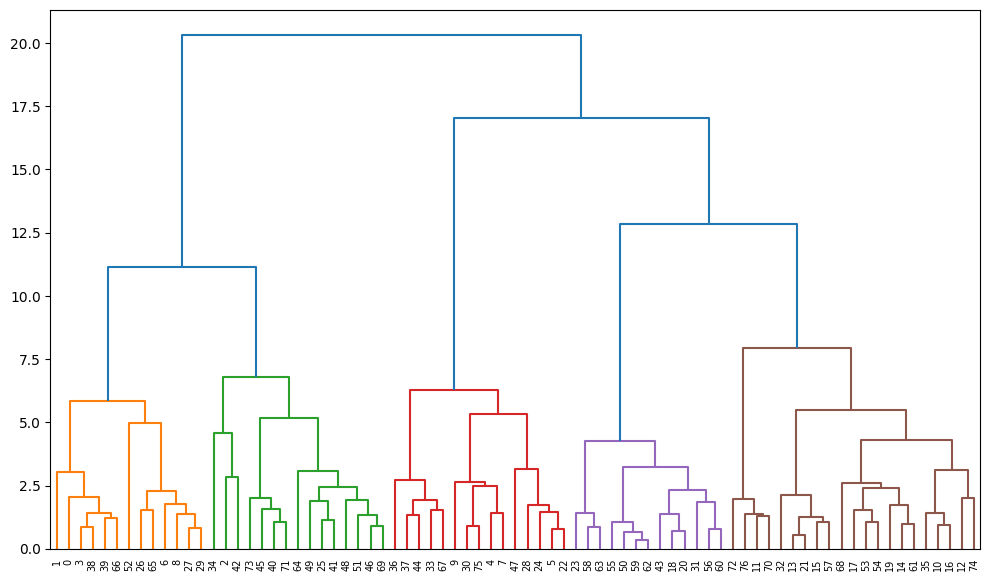

In [9]:
plt.figure(figsize=(12,7))
R1 = dendrogram(Z,orientation='top',leaf_rotation=90,
           leaf_font_size=7,color_threshold=Z[1-n_clusters,2])
plt.show()

The dendrogram illustrates the steps by which the clusters are constructed, with the horizontal bars drawn at the height of the corresponding distance. For example, from the contents of `Z` above, we know that the first step is to combine 59 and 62, for a distance of 0.36. Indeed, we can find the lowest horizontal bar connecting 59 and 62 in the purple cluster. The second grouping, between 13 and 21, for a distance of 0.54 is shown in the brown cluster, etc.

An interesting side result of the dendrogram calculation dictionary is the `"leaves_color_list"` item. It contains the color codes associated with each cluster as a distinct string. We can now use the `cluster_stats` function from our helper module to create a table with the cluster cardinality. Note that unlike what is the case in scikit-learn, cluster labels are not explicitly provided by the scipy.cluster functionality.

The result again shows the five clusters, but now in a slightly different order.

In [11]:
print(cluster_stats(R1["leaves_color_list"]))

  Labels Cardinality
0     C1          13
1     C2          15
2     C3          15
3     C4          13
4     C5          21


#### `plot_dendrogram` helper function

The helper function `plot_dendrogram` provides a one-line way to create a dendrogram plot. The first required argument is either the result of a `linkage` function as input (a numpy array), or a standardized data matrix. The default is to have the linkage result. If a standardized data matrix is the input, then the argument `package` must be set to `"scikit"` (the default is `"scipy"`, for a linkage result). The second required argument is the number of clusters, `n_clusters`.

Other arguments include `labels` (default `None`) for any labels other than sequence numbers to be assigned to the leaves of the graph, a linkage method (default `"ward"`, only required when a standardized array is passed, otherwise ignored), and a couple of customizations of the plot. These consist of `figsize` (default `(12,7)`), and `title` (default "Dendrogram").

Note that this function only works well for smallish data sets. Large data sets require further customization, not further considered here.

In the example below, we pass `X`, keep the number of clusters to `n_clusters`, set
the `package="scikit"`, use the `community` variable from the data frame as the labels, and customize the title to `"Ward Dendrogram"`. The result dictionary is passed to `R2`, which is then used to summarize the cluster labels. The dendrogram is identical to the one above, except that now the community area names are used as labels for the observations.

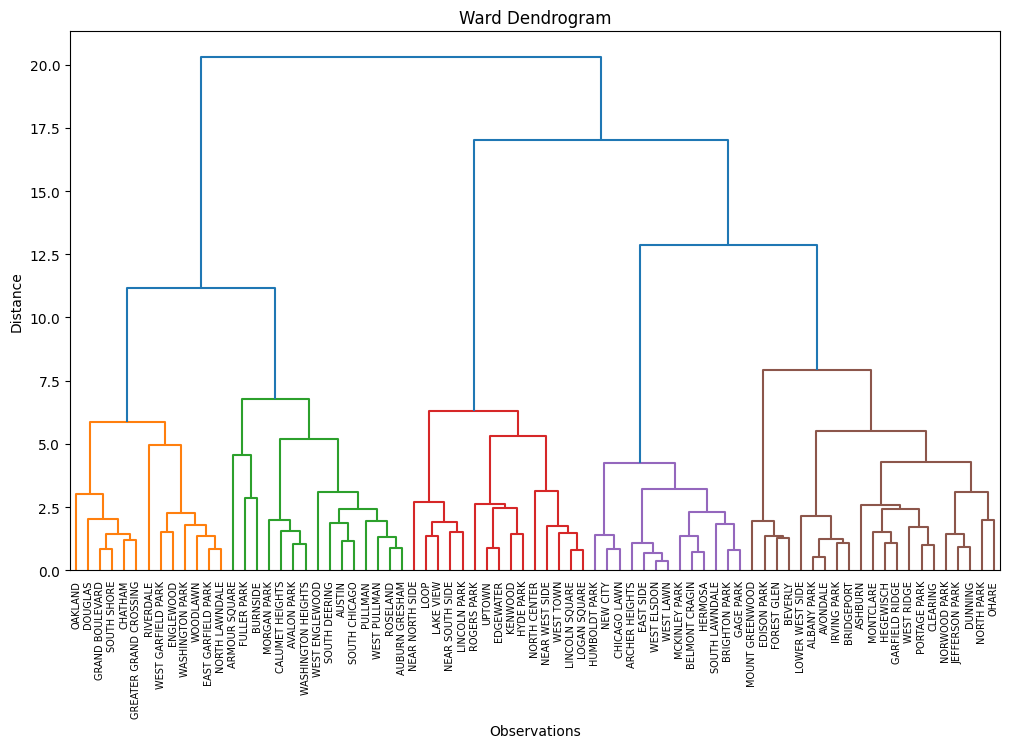

In [12]:
R2 = plot_dendrogram(X,n_clusters=n_clusters,package="scikit",labels=dfs['community'].values, 
                title="Ward Dendrogram")

In [15]:
print(cluster_stats(R2["leaves_color_list"]))

  Labels Cardinality
0     C1          13
1     C2          15
2     C3          15
3     C4          13
4     C5          21


### Cluster Centers

A useful property of each cluster is its *center*, i.e., the mean or median of the variables for those observations included in the cluster.

We accomplish this by means of a `gropuby` computation on the cluster labels. These are first added to the data frame with the original observations (not the standardized values). The resulting centers can be visualized in a number of different ways, for example in a parallel coordinate plot or as a conditional box plot. This is not further pursued here.

In [16]:
dt_clust = data_cluster.copy().assign(cluster=cluster_labels)
clust_means = dt_clust.groupby('cluster').mean()
clust_medians = dt_clust.groupby('cluster').median()
print("Cluster Means \n",np.round(clust_means,2))
print("Cluster Medians \n",np.round(clust_medians,2))

Cluster Means 
          INCPERCAP  Und20   Ov65  Minrty  Unemprt  Noveh  Lt_high  Rentocc  \
cluster                                                                      
0         34837.81  24.17  14.66   50.99     5.46   5.66    13.66    33.37   
1         22405.93  23.39  19.44   94.75    16.61  13.73    16.41    40.44   
2         62399.07  16.61  10.79   42.53     4.29  18.05     5.73    54.33   
3         18938.69  30.29  10.61   89.55    10.88   6.69    30.92    41.98   
4         19440.38  29.99  11.92   96.43    18.75  22.93    16.20    62.47   

         Rntburd  Noeng  
cluster                  
0          19.05  45.71  
1          28.29  12.52  
2          21.55  25.26  
3          25.13  73.03  
4          38.88   7.23  
Cluster Medians 
          INCPERCAP  Und20   Ov65  Minrty  Unemprt  Noveh  Lt_high  Rentocc  \
cluster                                                                      
0          31267.0  23.60  15.63   57.22     5.21   5.80    14.69    30.76   
1  

We have created a helper function in `spatial_cluster_course.py` to compute the cluster means and medians in a single command. The required arguments are a data frame with the variables used in the clustering exercise and an array of cluster labels. The function `cluster_center` returns a tuple with data frames of the means and medians.

To illustrate this, we pass the `data_cluster` data frame and the `R2["leaves_color_list"]` set of labels, and print out the means.

In [17]:
c_means,c_medians = cluster_center(data_cluster,R2["leaves_color_list"])
print(np.round(c_means,2))

         INCPERCAP  Und20   Ov65  Minrty  Unemprt  Noveh  Lt_high  Rentocc  \
cluster                                                                      
C1        32349.54  24.53  14.64   70.26    11.19  18.16    10.97    55.98   
C2        29496.73  25.42  11.35   69.98     7.73   9.53    19.70    47.75   
C3        40604.53  20.07  14.86   72.58     9.56  17.65    15.36    50.04   
C4        30449.69  26.57  13.76   77.16    12.43  10.43    16.15    38.07   
C5        30223.24  25.93  13.90   71.09    11.75   9.57    16.82    37.65   

         Rntburd  Noeng  
cluster                  
C1         28.84  23.32  
C2         26.47  46.41  
C3         26.31  28.09  
C4         23.28  31.36  
C5         24.31  35.32  


### Cluster Fit

The main objective of a clustering exercise is to decompose the total sum of squared differences from the mean (TSS) into a within cluster (WSS) and between cluster (BSS) part. The more similar the members of a cluster are, the smaller WSS will be. As a consequence, BSS will be larger, since the two are complements: TSS = WSS + BSS. The higher the ratio of BSS to WSS, the *better* the fit. 

Since we typically standardize the variables before the clustering exercise, the mean is zero and the variance for each variable equals 1, hence the TSS will equal k x n, where k is the number of variables and n is the number of observations. In our example, this would be 770. This is a direct result of how `StandardScaler` carries out the standardization, i.e., it uses n as the denominator in the computation of the variance/standard deviation. In contrast, `GeoDa` uses n-1 as the denominator (for an *unbiased* estimate). As a result, `GeoDa` will report 760 as the TSS. We address this in our helper function (`cluster_fit`), by rescaling `X` with $\sqrt{(n-1)/n}$.

First, we illustrate the steps using the `StandardScaler` approach. Note that the ratio BSS/TSS is not affected by the choice of the standardization, but the individual WSS and the TSS measures are.

In order to compute the WSS by cluster, we need to compute the cluster means. In contrast to what we just carried out, now the calculation must be done for the standardized variables, but otherwise the approach is the same, using `groupby` for the cluster labels. In each cluster, the WSS is the sum of squared deviations from the mean. The sum of all the cluster-specific WSS is the total WSS. The BSS is obtained as TSS - WSS. The final ratio is BSS/TSS.

First, the TSS.

In [18]:
tss = np.sum(np.square(X))
print("TSS",tss)

TSS 770.0


We compute the WSS for each cluster by first calculating the cluster mean using the same `groupby` approach as above, but now applied to the standardized variables. We then square the difference between each cluster member observation and the mean and sum the result.

In [19]:
data_tmp = data_cluster.copy().assign(cluster=cluster_labels)
wss_per_cluster = []
for cluster in range(n_clusters):
    cluster_data = X[data_tmp['cluster'] == cluster]
    cluster_mean = cluster_data.mean(axis=0)
    wss = np.sum(np.square(cluster_data - cluster_mean))
    wss_per_cluster.append(wss)
wss_per_cluster = [float(wss) for wss in wss_per_cluster]
print("Cluster WSS\n",np.round(wss_per_cluster,3))

Cluster WSS
 [81.496 68.007 57.317 22.29  44.942]


The total WSS is simply the sum of the cluster-specific WSS.

In [21]:
wss = np.sum(wss_per_cluster)
print("WSS ",np.round(wss,3))

WSS  274.052


Finally, the BSS is the complement of WSS, or TSS - WSS and the ratio BSS/TSS can be computed.

In [22]:
bss = tss - wss
btratio = bss/tss
print("BSS ",np.round(bss,3), "BSS/TSS ",np.round(btratio,3))

BSS  495.948 BSS/TSS  0.644


The helper function `cluster_fit` carries out these calculations and returns them as a dictionary, optionally listing the result.

Its required arguments are `data` for the original cluster variable observations, `clustlabels` for the cluster labels (to carry out the `groupby`), and `n_clusters`, the number of clusters. Optional arguments are `correct` (default is `False`) and `printopt` (default is `True`). Computing the standardized values with n-1 as the denominator is achieved by setting `correct = True`, and avoiding a listing of the results is set with `printopt = False`.

We first illustrate this for the standard options. The results are identical to those shown above.

In [23]:
clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels,
                 n_clusters=n_clusters)


Total Sum of Squares (TSS): 770.0
Within-cluster Sum of Squares (WSS) for each cluster: [81.496 68.007 57.317 22.29  44.942]
Total Within-cluster Sum of Squares (WSS): 274.052
Between-cluster Sum of Squares (BSS): 495.948
Ratio of BSS to TSS: 0.644


With `correct = True`, the standardization is different. The results now replicate those given by `GeoDa`. Note how the BSS/TSS ratio is unaffected.

In [24]:
clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels,
                 n_clusters=n_clusters,correct=True)


Total Sum of Squares (TSS): 760.0
Within-cluster Sum of Squares (WSS) for each cluster: [80.437 67.124 56.572 22.    44.358]
Total Within-cluster Sum of Squares (WSS): 270.493
Between-cluster Sum of Squares (BSS): 489.507
Ratio of BSS to TSS: 0.644


### Cluster Map

A final summary of the cluster results is a cluster map, a simple categorical thematic map that highlights the membership of clusters.

We proceed in the usual fashion, first adding the cluster labels to a temporary geodataframe, then creating a simple map for the `column` equal to the cluster label and the color map as `Set2`.

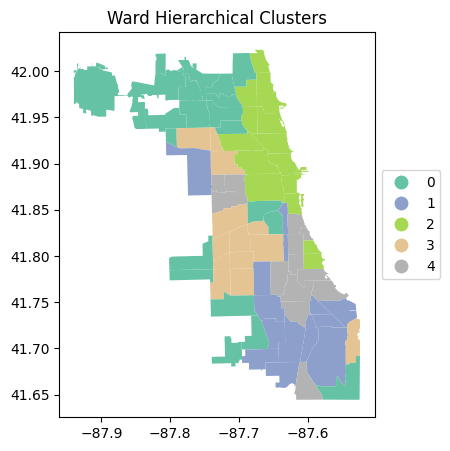

In [25]:
    gdf_temp = dfs.copy()
    gdf_temp['cluster'] = cluster_labels.astype(str) 
    fig, ax = plt.subplots(figsize=(5,5))
    gdf_temp.plot(column='cluster', ax=ax, legend=True, cmap='Set2',
            legend_kwds={'bbox_to_anchor': (1, 0.5), 'loc': 'center left'}) 
    ax.set_title("Ward Hierarchical Clusters")
    plt.show()

The cluster map is implemented in the helper function `cluster_map`, with some very simple defaults. It takes as required arguments the geodata frame and the cluster labels. Other arguments are `figsize` (default `(5,5)`), `title` (default `"Clusters"`), and `cmap` for the color map (default `"Set2"`).

In our example:

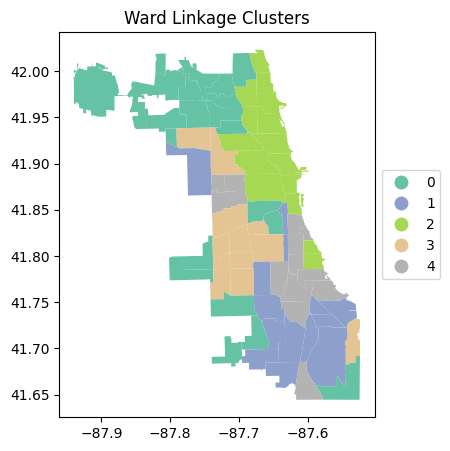

In [26]:
cluster_map(dfs, cluster_labels, figsize=(5,5), title="Ward Linkage Clusters", cmap='Set2')

## Other Linkage Functions

The other linkage functions are invoked with methods `"single"`, `"complete"` and `"average"`. Rather than completing the same commands each time, we create a loop over the linkage functions and use our helper functions to list the cluster results, centers, measures of fit and the cluster map.

---------------------------------

Clusters single linkage 
    Labels  Cardinality
0       0           73
1       1            1
2       2            1
3       3            1
4       4            1


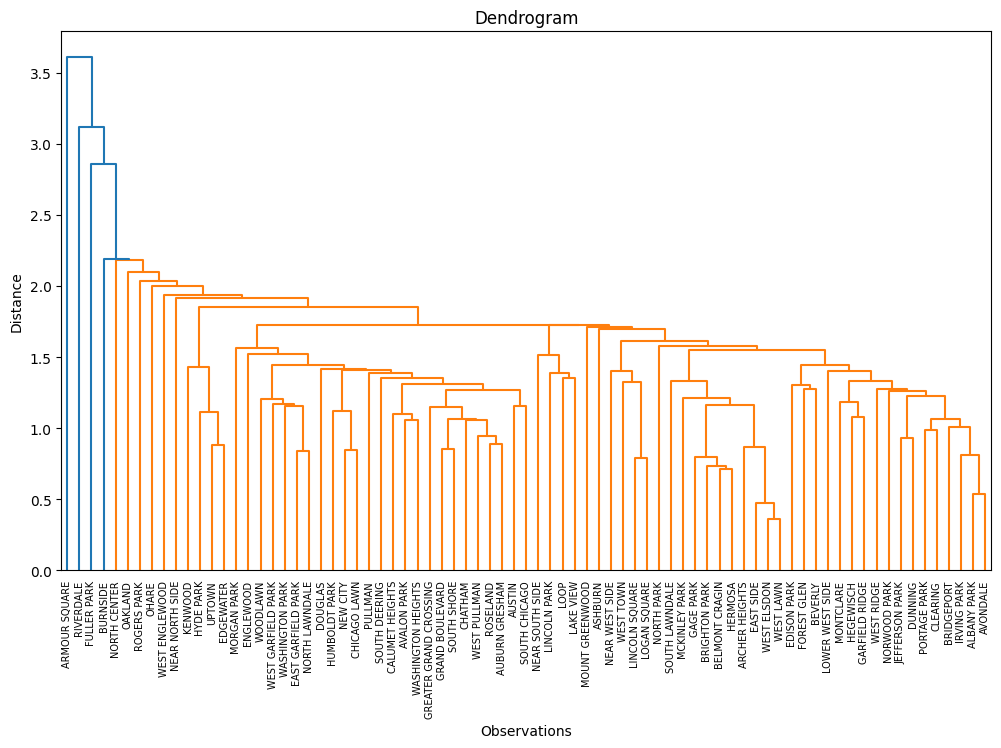

Cluster Means 
          INCPERCAP  Und20   Ov65  Minrty  Unemprt  Noveh  Lt_high  Rentocc  \
cluster                                                                      
0         33320.42  24.59  13.31   70.78    10.01  12.04    15.64    44.51   
1         19972.00  13.31  26.52   99.50    20.14  16.95    15.41    36.60   
2         11857.00  44.28   4.80   98.79    30.42  30.33    15.69    76.92   
3         16519.00  19.88  26.44   96.37    23.62  34.31    21.40    56.20   
4         21858.00  18.54  24.82   86.05     8.21  19.92    37.18    61.19   

         Rntburd  Noeng  
cluster                  
0          25.49  34.05  
1          29.95   4.41  
2          30.71   3.09  
3          31.26   7.38  
4          27.29  69.47  
Cluster Medians 
          INCPERCAP  Und20   Ov65  Minrty  Unemprt  Noveh  Lt_high  Rentocc  \
cluster                                                                      
0          26943.0  25.14  12.73   82.70     8.34  10.01    14.41    48.32   
1  

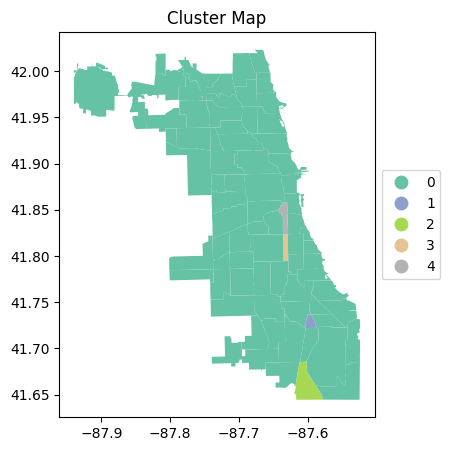

---------------------------------

Clusters complete linkage 
    Labels  Cardinality
0       0           21
1       1           29
2       2            3
3       3           10
4       4           14


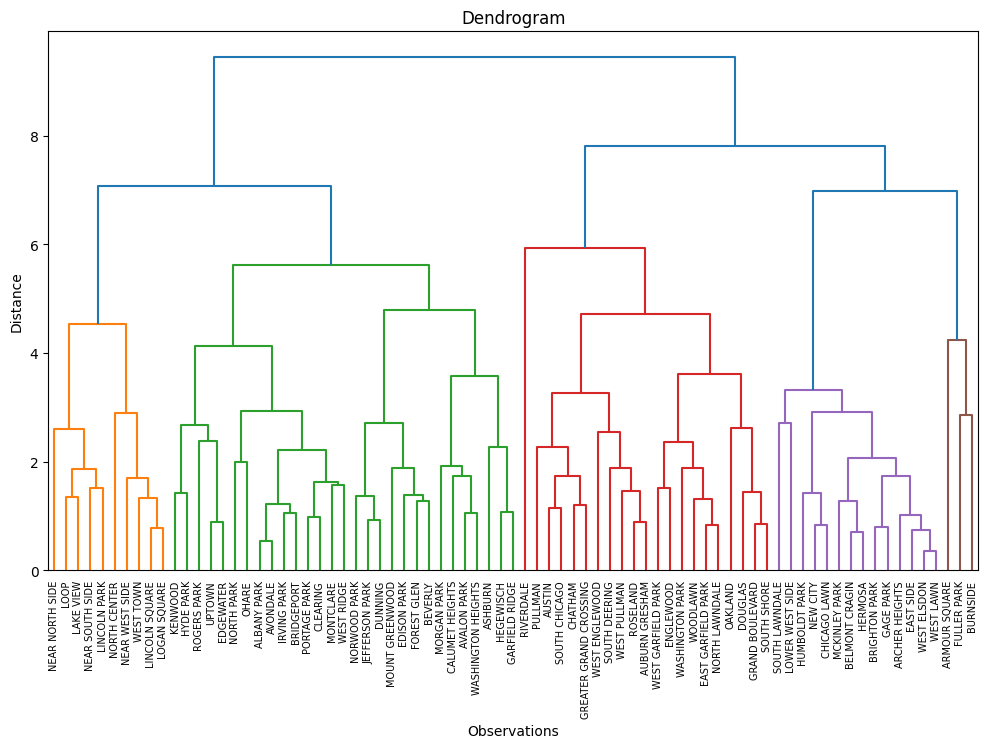

Cluster Means 
          INCPERCAP  Und20   Ov65  Minrty  Unemprt  Noveh  Lt_high  Rentocc  \
cluster                                                                      
0         19837.71  28.62  13.65   96.50    18.62  19.02    16.47    54.96   
1         35389.38  22.82  15.51   56.44     6.54   8.46    11.63    36.30   
2         19449.67  17.24  25.93   93.97    17.32  23.73    24.67    51.33   
3         72820.90  16.13   9.23   35.95     3.33  16.38     4.45    51.17   
4         19511.07  29.66  10.55   88.80    10.52   7.20    30.73    43.41   

         Rntburd  Noeng  
cluster                  
0          35.69   8.86  
1          20.52  36.37  
2          29.50  27.09  
3          19.69  23.27  
4          24.97  72.51  
Cluster Medians 
          INCPERCAP  Und20   Ov65  Minrty  Unemprt  Noveh  Lt_high  Rentocc  \
cluster                                                                      
0          19493.0  26.77  14.36   97.45    17.07  20.12    15.69    53.08   
1  

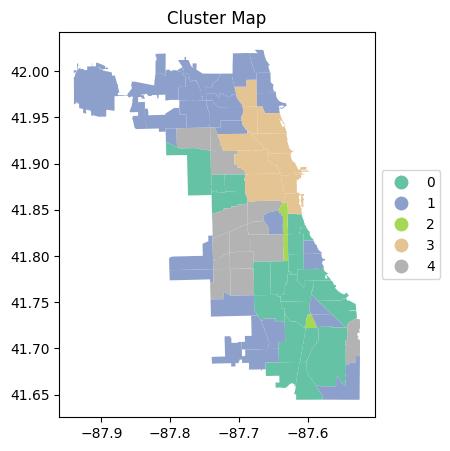

---------------------------------

Clusters average linkage 
    Labels  Cardinality
0       0           18
1       1           30
2       2           27
3       3            1
4       4            1


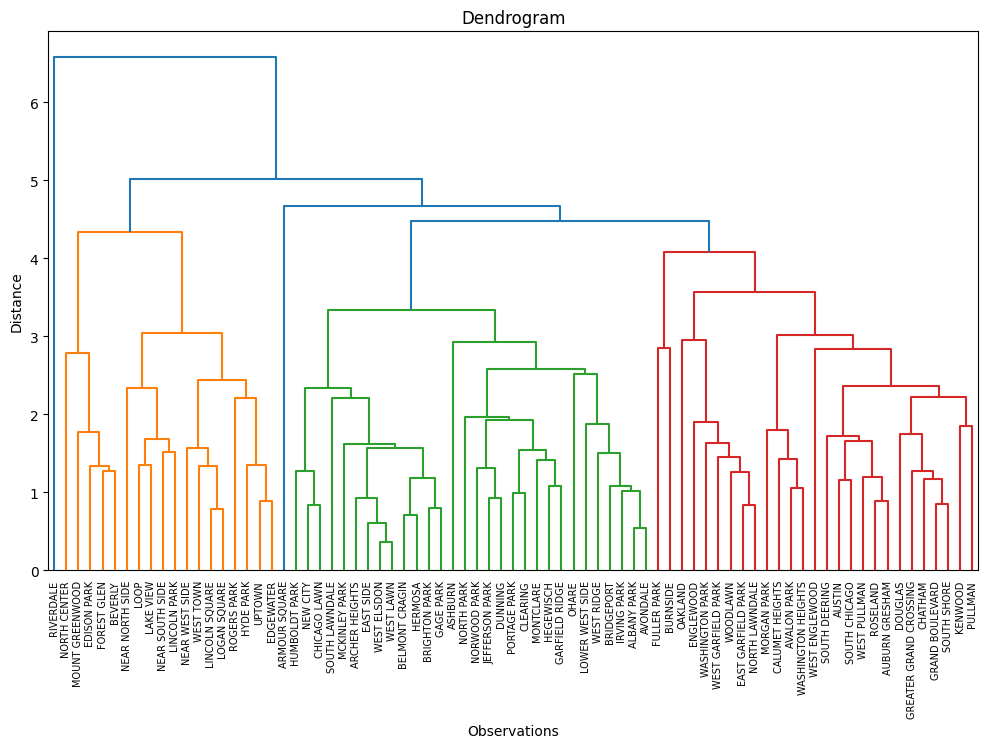

Cluster Means 
          INCPERCAP  Und20   Ov65  Minrty  Unemprt  Noveh  Lt_high  Rentocc  \
cluster                                                                      
0         60754.28  18.41  11.65   36.84     3.74  14.52     5.42    45.22   
1         25780.70  26.63  12.71   70.96     8.09   6.53    22.38    39.64   
2         22292.00  25.85  16.07   95.23    17.21  17.52    15.17    49.59   
3         21858.00  18.54  24.82   86.05     8.21  19.92    37.18    61.19   
4         11857.00  44.28   4.80   98.79    30.42  30.33    15.69    76.92   

         Rntburd  Noeng  
cluster                  
0          19.30  23.58  
1          22.54  61.68  
2          33.26   8.24  
3          27.29  69.47  
4          30.71   3.09  
Cluster Medians 
          INCPERCAP  Und20   Ov65  Minrty  Unemprt  Noveh  Lt_high  Rentocc  \
cluster                                                                      
0          55224.5  18.07  10.34   37.36     3.73  15.92     4.63    54.05   
1  

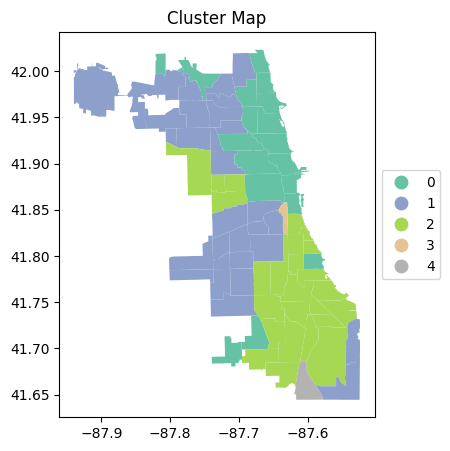

In [27]:
clustmethods = ['single','complete','average']
for cl in clustmethods:
    clust = AgglomerativeClustering(n_clusters=n_clusters, linkage=cl, compute_distances=True)
    clust.fit(X)
    cluster_labels = clust.labels_
    print("---------------------------------\n")
    print("Clusters",cl,"linkage \n",cluster_stats(cluster_labels))
    plot_dendrogram(X,n_clusters=n_clusters,package="scikit",
                    method=cl,labels=dfs['community'].values)
    c_means,c_medians = cluster_center(data_cluster,cluster_labels)
    print("Cluster Means \n",np.round(c_means,2))
    print("Cluster Medians \n",np.round(c_medians,2))
    clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels,
                 n_clusters=n_clusters)
    cluster_map(dfs, cluster_labels,title="Cluster Map")
    

The results highlight the superiority of Ward's method, with only Complete Linkage coming close with a BSS/TSS ratio of 0.60 (compared to 0.64 for Ward's method). Single linkage typically results in one or two very large clusters and several singletons. Average linkage is somewhere in-between.